# Import

In [35]:
import pandas as pd
import os
from os.path import join
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchvision.io import read_image
from matplotlib import pyplot as plt
import torchvision
import torch
import random
import h5py
import numpy as np
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

pd.options.display.max_columns = 700

BASE = ''
TABLES = join(BASE, 'tables_V2.0')
FEATURES = join(BASE, 'features')

front_view_only = False

from typing import List
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import k_means, SpectralClustering
import multiprocessing as mp

ANALYSIS = join(BASE, 'analysis')

def conf_matrix_from_matrices(mat_gt, mat_pred):
  overlap_and = (mat_pred & mat_gt)
  tp = overlap_and.sum()
  fp = mat_pred.sum()-overlap_and.sum()
  fn = mat_gt.sum()-overlap_and.sum()
  tn = mat_gt.shape[0]**2-(tp+fp+fn)
  return tp, fp, fn, tn

In [36]:
def check_or_save(obj, path, index=None, header=None):
  if isinstance(obj, pd.DataFrame):
    if index is None or header is None:
      raise ValueError('Index and header must be specified for saving a dataframe')
    if os.path.exists(path):
      if not header:
        saved_df = pd.read_csv(path,header=None)
      else:
        saved_df = pd.read_csv(path)
      naked_df = saved_df.reset_index(drop=True)
      naked_df.columns = range(naked_df.shape[1])
      naked_obj = obj.reset_index(drop=not index)
      naked_obj.columns = range(naked_obj.shape[1])
      if naked_df.round(6).equals(naked_obj.round(6)):
        return
      else:
        diff = (naked_df.round(6) == naked_obj.round(6))
        diff[naked_df.isnull()] = naked_df.isnull() & naked_obj.isnull()
        assert diff.all().all(), "Dataframe is not the same as saved dataframe"
    else:
      obj.to_csv(path, index=index, header=header)
  else:
    if os.path.exists(path):
      saved_obj = torch.load(path)
      if isinstance(obj, list):
        for i in range(len(obj)):
          check_array_equality(obj[i], saved_obj[i])
      else:
        check_array_equality(obj, saved_obj)
    else:
      print(f'Saving to {path}')
      torch.save(obj, path)


def check_array_equality(ob1, ob2):
  if torch.is_tensor(ob1) or isinstance(ob1, np.ndarray):
    assert (ob2 == ob1).all()
  else:
    assert ob2 == ob1

# Create Tabular Dataset

In [37]:
ad_data = pd.read_csv(join(TABLES, 'Ad_table.csv'))
ad_data.rename(columns={' Genmodel': 'Genmodel', ' Genmodel_ID': 'Genmodel_ID'}, inplace=True)

basic_data = pd.read_csv(join(TABLES, 'Basic_table.csv'))

image_data = pd.read_csv(join(TABLES, 'Image_table.csv'))
image_data.rename(columns={' Image_ID': 'Image_ID', ' Image_name': 'Image_name', ' Predicted_viewpoint':'Predicted_viewpoint', ' Quality_check':'Quality_check'}, inplace=True)

price_data = pd.read_csv(join(TABLES, 'Price_table.csv'))
price_data.rename(columns={' Genmodel': 'Genmodel', ' Genmodel_ID': 'Genmodel_ID', ' Year': 'Year', ' Entry_price': 'Entry_price'}, inplace=True)

sales_data = pd.read_csv(join(TABLES, 'Sales_table.csv'))
sales_data.rename(columns={'Genmodel ': 'Genmodel', 'Genmodel_ID ': 'Genmodel_ID'}, inplace=True)

trim_data = pd.read_csv(join(TABLES, 'Trim_table.csv'))

C:\Users\srira\AppData\Local\Temp\ipykernel_48952\622457649.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  ad_data = pd.read_csv(join(TABLES, 'Ad_table.csv'))


In [38]:
def parser_adv_id(x):
  split = x["Image_ID"].split('$$')
  return f"{split[0]}$${split[1]}"

image_data["Adv_ID"] = image_data.apply(lambda x: parser_adv_id(x), axis=1)
if front_view_only:
  image_data = image_data[(image_data["Quality_check"]=="P")&(image_data["Predicted_viewpoint"]==0)]
image_data.drop_duplicates(subset=['Adv_ID'], inplace=True)
image_data

,Genmodel_ID,Image_ID,Image_name,Predicted_viewpoint,Quality_check,Adv_ID
0,2_1,2_1$$1$$1,Abarth$$124 Spider$$2017$$Blue$$2_1$$1$$image_...,45,NaN,2_1$$1
1,2_1,2_1$$10$$11,Abarth$$124 Spider$$2017$$Blue$$2_1$$10$$image...,45,NaN,2_1$$10
8,2_1,2_1$$4$$0,Abarth$$124 Spider$$2017$$Blue$$2_1$$4$$image_...,0,P,2_1$$4
14,2_1,2_1$$8$$3,Abarth$$124 Spider$$2017$$Blue$$2_1$$8$$image_...,0,NaN,2_1$$8
18,2_1,2_1$$13$$8,Abarth$$124 Spider$$2017$$Grey$$2_1$$13$$image...,0,P,2_1$$13
...,...,...,...,...,...,...
1451766,96_18,96_18$$919$$3,Volvo$$XC90$$2019$$White$$96_18$$919$$image_3.jpg,225,NaN,96_18$$919
1451771,97_1,97_1$$1$$1,Westfield$$Sport$$2006$$Yellow$$97_1$$1$$image...,45,NaN,97_1$$1
1451772,99_1,99_1$$2$$14,Zenos$$E10$$2016$$Green$$99_1$$2$$image_14.jpg,180,NaN,99_1$$2
1451775,99_1,99_1$$3$$1,Zenos$$E10$$2016$$Grey$$99_1$$3$$image_1.jpg,0,P,99_1$$3


In [39]:
print(len(ad_data))
feature_df = ad_data.merge(price_data[['Genmodel_ID', 'Entry_price', 'Year']], left_on=['Genmodel_ID','Reg_year'], right_on=['Genmodel_ID','Year'])
print(len(feature_df))
feature_df

268255
224724


,Maker,Genmodel,Genmodel_ID,Adv_ID,Adv_year,Adv_month,Color,Reg_year,Bodytype,Runned_Miles,Engin_size,Gearbox,Fuel_type,Price,Seat_num,Door_num,Entry_price,Year
0,Bentley,Arnage,10_1,10_1$$1,2018,4,Silver,2000.0,Saloon,60000,6.8L,Automatic,Petrol,21500,5.0,4.0,145000,2000
1,Bentley,Arnage,10_1,10_1$$13,2018,4,Silver,2000.0,Saloon,53444,6.8L,Automatic,Petrol,21995,5.0,4.0,145000,2000
2,Bentley,Arnage,10_1,10_1$$15,2018,4,Black,2000.0,Saloon,61500,6.7L,Automatic,Petrol,16500,NaN,NaN,145000,2000
3,Bentley,Arnage,10_1,10_1$$16,2017,12,Blue,2000.0,Saloon,49700,4.4L,Automatic,Petrol,29500,5.0,4.0,145000,2000
4,Bentley,Arnage,10_1,10_1$$18,2018,4,White,2000.0,Saloon,75000,6.8L,Automatic,Petrol,17995,5.0,4.0,145000,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224719,Volvo,V50,96_9,96_9$$353,2018,5,Silver,2004.0,Estate,100390,2.4L,Automatic,Petrol,1999,5.0,5.0,17165,2004
224720,Volvo,V50,96_9,96_9$$374,2018,5,Silver,2004.0,Estate,149000,2.0L,Manual,Diesel,1450,5.0,5.0,17165,2004
224721,Volvo,V50,96_9,96_9$$457,2018,5,Grey,2004.0,Estate,98167,2.4L,Automatic,Petrol,3995,5.0,5.0,17165,2004
224722,Volvo,V50,96_9,96_9$$477,2018,2,Grey,2004.0,Estate,152230,1.8L,Manual,Petrol,1495,5.0,5.0,17165,2004


In [40]:
data_df = feature_df.merge(image_data[['Adv_ID', 'Image_name', 'Predicted_viewpoint']], left_on=['Adv_ID'], right_on=['Adv_ID'])
assert data_df["Adv_ID"].is_unique

In [41]:
def extract_engine_size(x):
  return float(x['Engin_size'][:-1])

data_df.dropna(inplace=True)
data_df['Engine_size'] = data_df.apply(lambda x: extract_engine_size(x), axis=1)
data_df.drop(columns=['Engin_size'], inplace=True)
data_df

,Maker,Genmodel,Genmodel_ID,Adv_ID,Adv_year,Adv_month,Color,Reg_year,Bodytype,Runned_Miles,Gearbox,Fuel_type,Price,Seat_num,Door_num,Entry_price,Year,Image_name,Predicted_viewpoint,Engine_size
0,Bentley,Arnage,10_1,10_1$$1,2018,4,Silver,2000.0,Saloon,60000,Automatic,Petrol,21500,5.0,4.0,145000,2000,Bentley$$Arnage$$2000$$Silver$$10_1$$1$$image_...,45,6.8
1,Bentley,Arnage,10_1,10_1$$13,2018,4,Silver,2000.0,Saloon,53444,Automatic,Petrol,21995,5.0,4.0,145000,2000,Bentley$$Arnage$$2000$$Silver$$10_1$$13$$image...,0,6.8
3,Bentley,Arnage,10_1,10_1$$16,2017,12,Blue,2000.0,Saloon,49700,Automatic,Petrol,29500,5.0,4.0,145000,2000,Bentley$$Arnage$$2000$$Blue$$10_1$$16$$image_1...,0,4.4
4,Bentley,Arnage,10_1,10_1$$18,2018,4,White,2000.0,Saloon,75000,Automatic,Petrol,17995,5.0,4.0,145000,2000,Bentley$$Arnage$$2000$$White$$10_1$$18$$image_...,90,6.8
5,Bentley,Arnage,10_1,10_1$$26,2017,5,Silver,2000.0,Saloon,98000,Automatic,Petrol,17945,5.0,4.0,145000,2000,Bentley$$Arnage$$2000$$Silver$$10_1$$26$$image...,225,6.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209030,Volvo,V50,96_9,96_9$$353,2018,5,Silver,2004.0,Estate,100390,Automatic,Petrol,1999,5.0,5.0,17165,2004,Volvo$$V50$$2004$$Silver$$96_9$$353$$image_0.jpg,45,2.4
209031,Volvo,V50,96_9,96_9$$374,2018,5,Silver,2004.0,Estate,149000,Manual,Diesel,1450,5.0,5.0,17165,2004,Volvo$$V50$$2004$$Silver$$96_9$$374$$image_0.jpg,0,2.0
209032,Volvo,V50,96_9,96_9$$457,2018,5,Grey,2004.0,Estate,98167,Automatic,Petrol,3995,5.0,5.0,17165,2004,Volvo$$V50$$2004$$Grey$$96_9$$457$$image_0.jpg,45,2.4
209033,Volvo,V50,96_9,96_9$$477,2018,2,Grey,2004.0,Estate,152230,Manual,Petrol,1495,5.0,5.0,17165,2004,Volvo$$V50$$2004$$Grey$$96_9$$477$$image_0.jpg,315,1.8


In [42]:
id_df = data_df.loc[:,'Adv_ID']
image_name_df = data_df.loc[:,'Image_name']
viewpoint_df = data_df.loc[:,'Predicted_viewpoint']

continuous_df = data_df.loc[:,(
  'Adv_year',
  'Adv_month',
  'Reg_year',
  'Runned_Miles',
  'Price',
  'Seat_num',
  'Door_num',
  'Entry_price', 
  'Engine_size'
  )]

categorical_ids = ['Color',
  'Bodytype',
  'Gearbox',
  'Fuel_type',
  'Genmodel_ID']



categorical_df = data_df.loc[:,categorical_ids]

continuous_df['Runned_Miles'] = pd.to_numeric(continuous_df['Runned_Miles'], errors='coerce')
continuous_df['Price'] = pd.to_numeric(continuous_df['Price'], errors='coerce')

# normalize
continuous_df=(continuous_df-continuous_df.mean())/continuous_df.std()

categorical_df['Color'] = categorical_df['Color'].astype('category')
categorical_df['Bodytype'] = categorical_df['Bodytype'].astype('category')
categorical_df['Gearbox'] = categorical_df['Gearbox'].astype('category')
categorical_df['Fuel_type'] = categorical_df['Fuel_type'].astype('category')
categorical_df['Genmodel_ID'] = categorical_df['Genmodel_ID'].astype('category')

cat_columns = categorical_df.select_dtypes(['category']).columns

categorical_df[cat_columns] = categorical_df[cat_columns].apply(lambda x: x.cat.codes)

data_df = pd.concat([id_df, continuous_df, categorical_df, image_name_df, viewpoint_df], axis=1)
data_df.dropna(inplace=True)

In [43]:
minimum_population = 100
values = (data_df.value_counts(subset=['Genmodel_ID'])>=minimum_population).values
codes = (data_df.value_counts(subset=['Genmodel_ID'])>=minimum_population).index
populated_codes = []
for i, v in enumerate(values):
  if v:
    populated_codes.append(int(codes[i][0]))

In [44]:
len(populated_codes)

286

In [45]:
data_df = data_df[data_df['Genmodel_ID'].isin(populated_codes)]
map = {}
for i,l in enumerate(data_df['Genmodel_ID'].unique()):
  map[l] = i
data_df['Genmodel_ID'] = data_df['Genmodel_ID'].map(map)
data_df

,Adv_ID,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,Door_num,Entry_price,Engine_size,Color,Bodytype,Gearbox,Fuel_type,Genmodel_ID,Image_name,Predicted_viewpoint
28,10_3$$1,0.012811,-1.311853,0.876887,-0.906021,6.323766,0.135216,0.61833,6.285820,5.331307,8,10,0,8,0,Bentley$$Bentayga$$2016$$Grey$$10_3$$1$$image_...,225
29,10_3$$3,0.012811,-0.830929,0.876887,-0.848026,6.594044,0.135216,0.61833,6.285820,5.331307,18,10,0,8,0,Bentley$$Bentayga$$2016$$Silver$$10_3$$3$$imag...,225
31,10_3$$10,0.012811,0.130919,0.876887,-0.815638,6.210746,0.135216,0.61833,6.285820,5.331307,2,10,0,8,0,Bentley$$Bentayga$$2016$$Blue$$10_3$$10$$image...,225
32,10_3$$11,0.012811,0.611842,0.876887,-0.823261,6.108246,0.135216,0.61833,6.285820,5.331307,20,10,0,8,0,Bentley$$Bentayga$$2016$$White$$10_3$$11$$imag...,0
33,10_3$$12,0.012811,0.130919,0.876887,-1.061788,7.133519,0.135216,0.61833,6.285820,5.331307,8,10,0,8,0,Bentley$$Bentayga$$2016$$Grey$$10_3$$12$$image...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209030,96_9$$353,0.012811,-0.350005,-1.900760,1.145516,-0.581038,0.135216,0.61833,-0.204064,0.666012,18,4,0,8,285,Volvo$$V50$$2004$$Silver$$96_9$$353$$image_0.jpg,45
209031,96_9$$374,0.012811,-0.350005,-1.900760,2.282258,-0.610655,0.135216,0.61833,-0.204064,0.147646,18,4,1,1,285,Volvo$$V50$$2004$$Silver$$96_9$$374$$image_0.jpg,0
209032,96_9$$457,0.012811,-0.350005,-1.900760,1.093532,-0.473358,0.135216,0.61833,-0.204064,0.666012,8,4,0,8,285,Volvo$$V50$$2004$$Grey$$96_9$$457$$image_0.jpg,45
209033,96_9$$477,0.012811,-1.792777,-1.900760,2.357791,-0.608227,0.135216,0.61833,-0.204064,-0.111537,8,4,1,8,285,Volvo$$V50$$2004$$Grey$$96_9$$477$$image_0.jpg,315


In [46]:
bad_indices = []
for indx, row in data_df.iterrows():
    im_name = row['Image_name']
    split = im_name.split('$$')
    path = join(BASE, 'resized_DVM', split[0], split[1], split[2], split[3], im_name)
    if not os.path.exists(path):
        bad_indices.append(path)

In [47]:
_ids = list(data_df['Adv_ID'])
addendum = '_all_views'
non_feature_columns = ['Adv_ID', 'Image_name', 'Predicted_viewpoint', 'Genmodel_ID']
if front_view_only:
  train_set_ids, test_ids = train_test_split(_ids, test_size=0.1, random_state=2022)
  train_ids, val_ids = train_test_split(train_set_ids, test_size=0.2, random_state=2022)
  
  bad_indices_train = torch.load(join(FEATURES, f'bad_indices_train{addendum}.pt'))
  bad_indices_val = torch.load(join(FEATURES, f'bad_indices_val{addendum}.pt'))

  print(f'Val length before {len(val_ids)}')
  for _id in bad_indices_val:
      val_ids.remove(_id)
  print(f'Val length after {len(val_ids)}')

  print(f'Train length before {len(train_ids)}')
  for _id in bad_indices_train:
      train_ids.remove(_id)
  print(f'Train length after {len(train_ids)}')
else:
  addendum = '_all_views'
  train_set_ids, test_ids = train_test_split(_ids, test_size=0.5, random_state=2022, stratify=data_df['Genmodel_ID'])
  train_ids, val_ids = train_test_split(train_set_ids, test_size=0.2, random_state=2022, stratify=data_df[data_df['Adv_ID'].isin(train_set_ids)]['Genmodel_ID'])

check_or_save(train_ids, join(FEATURES, f'train_ids{addendum}.pt'))
check_or_save(val_ids, join(FEATURES, f'val_ids{addendum}.pt'))
check_or_save(test_ids, join(FEATURES, f'test_ids{addendum}.pt'))

train_df = data_df.set_index('Adv_ID').loc[train_ids]
val_df = data_df.set_index('Adv_ID').loc[val_ids]
test_df = data_df.set_index('Adv_ID').loc[test_ids]

train_labels_all = list(train_df['Genmodel_ID'])
val_labels_all = list(val_df['Genmodel_ID'])
test_labels_all = list(test_df['Genmodel_ID'])

check_or_save(train_labels_all, join(FEATURES,f'labels_model_all_train{addendum}.pt'))
check_or_save(val_labels_all, join(FEATURES,f'labels_model_all_val{addendum}.pt'))
check_or_save(test_labels_all, join(FEATURES,f'labels_model_all_test{addendum}.pt'))

check_or_save(train_df.loc[:,~train_df.columns.isin(non_feature_columns)],join(FEATURES,f'dvm_features_train_noOH{addendum}.csv'), index=False, header=False)
check_or_save(val_df.loc[:,~val_df.columns.isin(non_feature_columns)],join(FEATURES,f'dvm_features_val_noOH{addendum}.csv'), index=False, header=False)
check_or_save(test_df.loc[:,~test_df.columns.isin(non_feature_columns)],join(FEATURES,f'dvm_features_test_noOH{addendum}.csv'), index=False, header=False)

check_or_save(train_df, join(FEATURES,f'dvm_full_features_train_noOH{addendum}.csv'), index=True, header=True)
check_or_save(val_df, join(FEATURES,f'dvm_full_features_val_noOH{addendum}.csv'), index=True, header=True)
check_or_save(test_df, join(FEATURES,f'dvm_full_features_test_noOH{addendum}.csv'), index=True, header=True)

lengths = [1 for i in range(len(continuous_df.columns))]

if 'Genmodel_ID' in categorical_ids:
  categorical_ids.remove('Genmodel_ID')
max = list(data_df[categorical_ids].max(axis=0))
max = [i+1 for i in max]
lengths = lengths + max
check_or_save(lengths, join(FEATURES, f'tabular_lengths{addendum}.pt'))

Saving to features\train_ids_all_views.pt
Saving to features\val_ids_all_views.pt
Saving to features\test_ids_all_views.pt
Saving to features\labels_model_all_train_all_views.pt
Saving to features\labels_model_all_val_all_views.pt
Saving to features\labels_model_all_test_all_views.pt
Saving to features\tabular_lengths_all_views.pt


In [48]:
def get_paths(df):
  paths = []
  for indx, row in df.iterrows():
      im_name = row['Image_name']
      split = im_name.split('$$')
      path = join(BASE, 'resized_DVM', split[0], split[1], split[2], split[3], im_name)
      paths.append(path)
  return paths

# For big dataset need to save only paths to load live
addendum = '_all_views'
train_df = pd.read_csv(join(FEATURES,f'dvm_full_features_train_noOH{addendum}.csv'))
val_df = pd.read_csv(join(FEATURES,f'dvm_full_features_val_noOH{addendum}.csv'))
test_df = pd.read_csv(join(FEATURES,f'dvm_full_features_test_noOH{addendum}.csv'))

for df, name in zip([train_df, val_df, test_df], ['train', 'val', 'test']):
  paths = get_paths(df)
  check_or_save(paths, join(FEATURES, f'{name}_paths{addendum}.pt'))

Saving to features\train_paths_all_views.pt
Saving to features\val_paths_all_views.pt
Saving to features\test_paths_all_views.pt


# Save Normalized Ims

In [34]:
import h5py

if front_view_only:
  IMAGES = join(BASE, 'Confirmed_fronts')
else:
  IMAGES = join(BASE, 'resized_DVM')

for df, t_split in zip([train_df, val_df, test_df], ['train', 'val', 'test']):
    num_images = len(df)
    
    # Read one image to get the shape
    sample_image_name = df.iloc[0]['Image_name']
    split = sample_image_name.split('$$')
    if front_view_only:
        sample_path = join(IMAGES, split[0], split[2], sample_image_name)
    else:
        sample_path = join(IMAGES, split[0], split[1], split[2], split[3], sample_image_name)
    sample_image = read_image(sample_path)
    image_shape = sample_image.shape  # (channels, height, width)

    # Open an HDF5 file to store the images
    h5_file_path = join(FEATURES, f'{t_split}_images{addendum}.h5')
    with h5py.File(h5_file_path, 'w') as h5f:
        # Create a dataset to store all images
        dset = h5f.create_dataset('images', shape=(num_images,) + image_shape, dtype='float32')
        
        for idx, row in enumerate(df.itertuples()):
            image_name = row.Image_name
            split = image_name.split('$$')
            
            if front_view_only:
                path = join(IMAGES, split[0], split[2], image_name)
            else:
                path = join(IMAGES, split[0], split[1], split[2], split[3], image_name)
            
            image = read_image(path).float() / 255  # Normalize the image
            dset[idx] = image.numpy()
            
            # Optionally, print progress
            if (idx + 1) % 1000 == 0:
                print(f'Processed {idx + 1}/{num_images} images')

Processed 1000/70565 images
Processed 2000/70565 images
Processed 3000/70565 images
Processed 4000/70565 images
Processed 5000/70565 images
Processed 6000/70565 images
Processed 7000/70565 images
Processed 8000/70565 images
Processed 9000/70565 images
Processed 10000/70565 images
Processed 11000/70565 images
Processed 12000/70565 images
Processed 13000/70565 images
Processed 14000/70565 images
Processed 15000/70565 images
Processed 16000/70565 images
Processed 17000/70565 images
Processed 18000/70565 images
Processed 19000/70565 images
Processed 20000/70565 images
Processed 21000/70565 images
Processed 22000/70565 images
Processed 23000/70565 images
Processed 24000/70565 images
Processed 25000/70565 images
Processed 26000/70565 images
Processed 27000/70565 images
Processed 28000/70565 images
Processed 29000/70565 images
Processed 30000/70565 images
Processed 31000/70565 images
Processed 32000/70565 images
Processed 33000/70565 images
Processed 34000/70565 images
Processed 35000/70565 i

# Create Low Data Splits

In [49]:
def low_data_split(df, nclasses):
  critical_ids = df.groupby('Genmodel_ID', as_index=False).head(n=1)['Adv_ID']
  other_ids = df.loc[~df['Adv_ID'].isin(critical_ids)]['Adv_ID'].values
  to_fill_size = (int(len(df)*0.1)-len(critical_ids))
  stratify = None
  if to_fill_size >= nclasses:
    stratify = df.set_index('Adv_ID').loc[other_ids]['Genmodel_ID']
  if to_fill_size > 0:
    _, low_data_ids = train_test_split(other_ids, test_size=to_fill_size, random_state=2023, stratify=stratify)
  else:
    low_data_ids = []
  new_ids = np.concatenate([critical_ids,low_data_ids])
  return new_ids

In [52]:
addendum = '_all_views'
data_str = 'images'
location = ""
non_feature_columns = ['Image_name', 'Genmodel_ID', 'Predicted_viewpoint', 'Adv_ID']
nclasses = 151
if addendum == '_all_views':
    nclasses = 286

for k, prev_k in zip([0.1, 0.01], ['', '_0.1']):
    df = pd.read_csv(join(FEATURES, f'dvm_full_features_train_noOH{addendum}{prev_k}.csv'))
    ids = torch.load(join(FEATURES, f'train_ids{addendum}{prev_k}.pt'))

    # Open the HDF5 file
    h5_file_path = join(FEATURES, f'train_{data_str}{addendum}{location}{prev_k}.h5')
    h5f = h5py.File(h5_file_path, 'r')
    ims_dataset = h5f['images']  # Adjust the dataset name if different

    labels = torch.load(join(FEATURES, f'labels_model_all_train{addendum}{prev_k}.pt'))

    # Determine the low data IDs
    low_data_ids = low_data_split(df, nclasses)

    # Create a boolean mask for IDs in low_data_ids
    true_false_mask = np.array([i in low_data_ids for i in ids])

    # Filter the DataFrame and IDs
    low_data_df = df.loc[true_false_mask]
    low_data_ids = [id for id, keep in zip(ids, true_false_mask) if keep]

    # Get indices of images to select
    indices = np.where(true_false_mask)[0]

    # Select images using the indices
    low_data_ims = ims_dataset[indices]

    # Select corresponding labels
    low_data_labels = [labels[i] for i in indices]

    # Save the data
    check_or_save(low_data_df.loc[:, ~low_data_df.columns.isin(non_feature_columns)],
                  join(FEATURES, f'dvm_features_train_noOH{addendum}_{k}.csv'),
                  index=False, header=False)
    check_or_save(low_data_df,
                  join(FEATURES, f'dvm_full_features_train_noOH{addendum}_{k}.csv'),
                  index=False, header=True)

    # Save the selected images to a new HDF5 file or as needed
    with h5py.File(join(FEATURES, f'train_{data_str}{addendum}{location}_{k}.h5'), 'w') as h5f_out:
        h5f_out.create_dataset('images', data=low_data_ims)

    check_or_save(low_data_ids, join(FEATURES, f'train_ids{addendum}_{k}.pt'))
    check_or_save(low_data_labels, join(FEATURES, f'labels_model_all_train{addendum}_{k}.pt'))

    # Close the HDF5 file
    h5f.close()


Saving to features\train_ids_all_views_0.1.pt
Saving to features\labels_model_all_train_all_views_0.1.pt
Saving to features\train_ids_all_views_0.01.pt
Saving to features\labels_model_all_train_all_views_0.01.pt


In [53]:
split = 'train'
for k in [0.1, 0.01]:
  low_data_ids = torch.load(join(FEATURES, f'{split}_ids{addendum}_{k}.pt'))
  low_data_df = pd.read_csv(join(FEATURES,f'dvm_full_features_{split}_noOH{addendum}_{k}.csv'))
  print(low_data_df.value_counts('Genmodel_ID'))
  print(len(low_data_ids))

Genmodel_ID
257    192
31     138
40     107
32     104
261    103
      ... 
158      5
27       5
21       5
170      5
0        5
Length: 286, dtype: int64
7056
Genmodel_ID
257    13
31      9
40      8
181     7
256     7
       ..
203     1
246     1
44      1
251     1
0       1
Length: 286, dtype: int64
705


# Check Transforms

In [56]:
from torchvision import transforms
import torch
from os.path import join

BASE = ''
TABLES = join(BASE, 'tables_V2.0')
FEATURES = join(BASE, 'features')

Original image shape (C, H, W): (3, 300, 300)
Transposed image shape (H, W, C): (300, 300, 3)


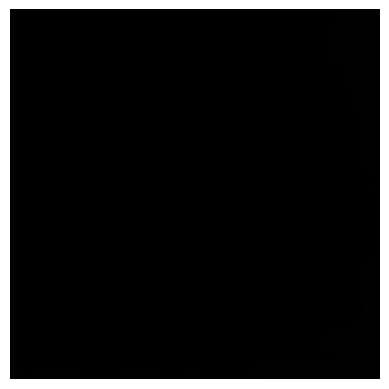

In [88]:
# Define the path to your HDF5 file
h5_file_path = join(FEATURES, 'train_images_all_views.h5')

# Open the HDF5 file in read mode
with h5py.File(h5_file_path, 'r') as h5f:
    # Access the dataset containing the images
    images_dataset = h5f['images']  # Adjust 'images' if your dataset name is different

    img_size = 128

    # Define your transformations
    transform = transforms.Compose([
        transforms.RandomApply([
            transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8)
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomApply([
            transforms.GaussianBlur(kernel_size=29, sigma=(0.1, 2.0))
        ], p=0.5),
        transforms.RandomResizedCrop(
            size=(img_size, img_size),
            scale=(0.2, 1.0),
            ratio=(0.75, 1.3333333333333333)
        ),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Resize(size=(img_size, img_size)),
        transforms.ToTensor(),  # Convert PIL Image to Tensor
        # Optionally, normalize the tensor
        # transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                      std=[0.229, 0.224, 0.225])
    ])

    # Access an image by index
    im_np = images_dataset[50]  # Replace '1' with any valid index
    print(f"Original image shape (C, H, W): {im_np.shape}")  # (3, 300, 300)

    # Transpose the NumPy array to (H, W, C)
    im_np_transposed = np.transpose(im_np, (1, 2, 0))
    print(f"Transposed image shape (H, W, C): {im_np_transposed.shape}")  # (300, 300, 3)

    # Convert the NumPy array to a PIL image
    im_pil = transforms.ToPILImage()(im_np_transposed.astype('uint8'))

    # Apply the transformations
    im_t = transform(im_pil)

    # Convert the transformed image back to a NumPy array for plotting
    im_t_np = im_t.permute(1, 2, 0).numpy()

    # Since im_t is in [0,1], multiply by 255 to get pixel values in [0,255]
    im_t_np = (im_t_np * 255).astype(np.uint8)

    # Plot the image
    plt.imshow(im_t_np)
    plt.axis('off')  # Hide axis
    plt.show()

In [93]:
# Define the path to your HDF5 file
h5_file_path = join(FEATURES, 'train_images_all_views.h5')
images_dataset = h5py.File(h5_file_path, 'r')['images']
images_dataset[1]

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32)

# New Physical Features

## Adding missing values to physical table

In [71]:
# Fill using other values
physical_df_orig = pd.read_csv(join('tables_V2.0','Ad_table (extra).csv'))
physical_df_orig.rename(columns={' Genmodel_ID':'Genmodel_ID', ' Genmodel':'Genmodel'}, inplace=True)

# Manual touches

# Peugeot RCZ
physical_df_orig.loc[physical_df_orig['Genmodel_ID'] == '69_36','Wheelbase']=2612
# Ford Grand C-Max
physical_df_orig.loc[physical_df_orig['Genmodel_ID'] == '29_20','Wheelbase']=2788 

def fill_from_other_entry(row):
    for attr in ['Wheelbase', 'Length', 'Width', 'Height']:
        if pd.isna(row[attr]) or row[attr]==0:
            other_rows = physical_df_orig.loc[physical_df_orig['Genmodel_ID']==row['Genmodel_ID']]
            other_rows.dropna(subset=[attr], inplace=True)
            other_rows.drop_duplicates(subset=[attr], inplace=True)
            other_rows = other_rows[other_rows[attr]>0]
            if len(other_rows)>0:
                row[attr] = other_rows[attr].values[0]
    return row

physical_df_orig = physical_df_orig.apply(fill_from_other_entry, axis=1)

physical_df_orig.to_csv(join(FEATURES,'Ad_table_physical_filled.csv'), index=False)

## Add physical attributes to features

In [72]:
# Add jitter to physical dimensions so they aren't just labels
def add_jitter(x, jitter=50):
    return x + random.randint(-jitter, jitter)

random.seed(2022)
physical_df = pd.read_csv(join(FEATURES,'Ad_table_physical_filled.csv'))
for attr in ['Wheelbase', 'Length', 'Width', 'Height']:
    physical_df[attr] = physical_df[attr].apply(add_jitter)
physical_df.to_csv(join(FEATURES,'Ad_table_physical_filled_jittered_50.csv'), index=False)

In [73]:
# Ford ranger (29_30) has wrong height. Missing 1 in front... 805.0 instead of 1805.0
# Mercedes Benz (59_29) wrong wheelbase, 5246.0 instead of 3106
# Kia Rio (43_9) wrong wheelbase, 4065.0 instead of 2580
# FIXED


physical_df = pd.read_csv(join(FEATURES,'Ad_table_physical_filled_jittered_50.csv'))[['Adv_ID', 'Wheelbase','Height','Width','Length']]
for v in ['_all_views']:
    for split in ['train', 'val', 'test']:
        features_df = pd.read_csv(join(FEATURES,f'dvm_full_features_{split}_noOH{v}.csv'))
        merged_df = features_df.merge(physical_df, on='Adv_ID')
        physical_only_df = merged_df[['Wheelbase','Height','Width','Length','Bodytype']]

        for attr in ['Wheelbase','Height','Width','Length']:
            assert merged_df[attr].isna().sum()==0
            assert (merged_df[attr]==0).sum()==0

        # normalize physical attributes
        for attr in ['Wheelbase','Height','Width','Length']:
            merged_df[attr] = (merged_df[attr]-merged_df[attr].mean())/merged_df[attr].std()
            physical_only_df[attr] = (physical_only_df[attr]-physical_only_df[attr].mean())/physical_only_df[attr].std()

        # Drop unwanted cols
        non_feature_columns = ['Adv_ID', 'Image_name', 'Genmodel_ID']
        if v == '_all_views':
            non_feature_columns.append('Predicted_viewpoint')
        merged_df = merged_df.drop(non_feature_columns, axis=1)

        merged_df_cols = merged_df.columns.tolist()
        rearranged_cols = merged_df_cols[-4:]+merged_df_cols[:-4]
        merged_df = merged_df[rearranged_cols]
        check_or_save(merged_df, join(FEATURES,f'dvm_features_{split}_noOH{v}_physical_jittered_50.csv'), index=False, header=False)
        check_or_save(physical_only_df, join(FEATURES,f'dvm_features_{split}_noOH{v}_physical_only_jittered_50.csv'), index=False, header=False)
    lengths = torch.load(join(FEATURES,f'tabular_lengths{v}.pt'))
    new_lengths = [1,1,1,1]
    lengths = new_lengths + lengths
    check_or_save(lengths, join(FEATURES,f'tabular_lengths{v}_physical.pt'))
    lengths = [1,1,1,1,13]
    check_or_save(lengths, join(FEATURES,f'tabular_lengths{v}_physical_only.pt'))

C:\Users\srira\AppData\Local\Temp\ipykernel_48952\2216702334.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  physical_only_df[attr] = (physical_only_df[attr]-physical_only_df[attr].mean())/physical_only_df[attr].std()
C:\Users\srira\AppData\Local\Temp\ipykernel_48952\2216702334.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  physical_only_df[attr] = (physical_only_df[attr]-physical_only_df[attr].mean())/physical_only_df[attr].std()
C:\Users\srira\AppData\Local\Temp\ipykernel_48952\2216702334.py:21

Saving to features\tabular_lengths_all_views_physical.pt
Saving to features\tabular_lengths_all_views_physical_only.pt


# Add Labels to Featues

In [86]:
for v in ['_all_views']:
    for split in ['train', 'val']:
        labels = torch.load(join(FEATURES,f'labels_model_all_{split}{v}.pt'))
        features = pd.read_csv(join(FEATURES,f'dvm_features_{split}_noOH{v}_physical_jittered_50.csv'), header=None)
        features['label'] = labels
        check_or_save(features, join(FEATURES,f'dvm_features_{split}_noOH{v}_physical_jittered_50_labeled.csv'), index=False, header=False)
    lengths = torch.load(join(FEATURES,f'tabular_lengths{v}_physical.pt'))
    lengths.append(np.array(labels).max()+1)
    check_or_save(lengths, join(FEATURES,f'tabular_lengths{v}_physical_labeled.pt'))

Saving to features\tabular_lengths_all_views_physical_labeled.pt
